# Behavioral Analysis

This notebook analyze the behavioral performance of individual sessions.

TODO:
- update unit data analyses to use saved out results files instead of loading from NWB

In [25]:
%config Completer.use_jedi = False

In [26]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import sem

from convnwb.io import load_nwbfile
from convnwb.io import get_files

from spiketools.plts.utils import make_axes, save_figure
from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.style import drop_spines
from spiketools.utils.base import count_elements

In [27]:
import sys
sys.path.append('../code')
from utils import compute_recall_percent, get_confidence_response

In [28]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [29]:
# Define the base data folder
#data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'
data_folder = '/data12/jacobs_lab/WVTH/nwb'
#data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/NWB'

#### Plot Settings

In [30]:
# Plot colors
colors = {
    'default' : 'silver',
    'face' : '#0F7AC0',
    'obj' : '#D95319',  
}

## Load data

In [31]:
# Get the list of NWB files
nwbfiles = get_files(data_folder, select='nwb')

In [32]:
# Get the list of NWB files running THO, THF respectively
nwbfiles_THF = get_files(data_folder, select='THF')
nwbfiles_THO = get_files(data_folder, select='THO')

## Recall correctness

In [41]:
# Set the path to the one-back behavioral data file
#nback_path = '/Users/clairehan/Desktop/research/WVTH/'
#nback_path = '/Users/tom/Documents/Research/2-Projects/1b-Current(Jacobs)/TH/zRESULTS/'
nback_path = '/data12/jacobs_lab/WVTH/info/nback/'

# Set the filename for the one-back behavioral data file
nback_filename = 'behAcc.mat'

In [42]:
# Load the one-back behavioral data results
behav_nback = sio.loadmat(nback_path + nback_filename)

In [43]:
# plot % of recall for one-back data
correct_OBF = (behav_nback['AccCel'][0]) * 100
correct_OBO = (behav_nback['AccImg'][0]) * 100

In [44]:
# Compute the percentage of recall for all data, and for each task
correct_THF = compute_recall_percent(nwbfiles_THF, data_folder)
correct_THO = compute_recall_percent(nwbfiles_THO, data_folder)

In [ ]:
# Collect together accuracy data
y_OB = [correct_OBF, correct_OBO]
y_TH = [correct_THF, correct_THO]

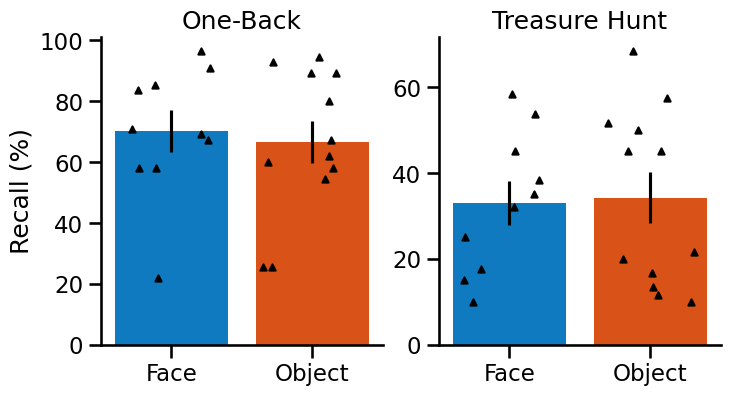

In [51]:
# Plot the accuracy of each task
ax1, ax2 = make_axes(2, 2, figsize=(8,4))

plot_bar([correct_OBF.mean(0), correct_OBO.mean(0)], ['Face', 'Object'], ylabel='Recall (%)', title='One-Back',
         yerr=[sem(correct_OBF, 0), sem(correct_OBO, 0)], ax=ax1, color=['#0F7AC0', '#D95319'], zorder=0)
plot_bar([correct_THF.mean(0), correct_THO.mean(0)], ['Face', 'Object'], title='Treasure Hunt',
         yerr=[sem(correct_THF, 0), sem(correct_THO, 0)], ax=ax2, color=['#0F7AC0', '#D95319'], zorder=0)
w = 0.7
for ii in [0, 1]:
    ax1.scatter(ii + np.random.random(y_OB[ii].size) * w - w / 2, y_OB[ii], color='black', marker='^', s=20)
    ax2.scatter(ii + np.random.random(y_TH[ii].size) * w - w / 2, y_TH[ii], color='black', marker='^', s=20)
for cax in [ax1, ax2]:
    drop_spines(cax, ['top', 'right'])
# save_figure('behav'+'.svg', '/Users/clairehan/Desktop/paper_fig', close=False, bbox_inches='tight')

### TH: Confidence Responses

In [52]:
# Count the number of confidence response in each category across sessions
[conf_all, conf_THF, conf_THO] = Counter({'yes': 0, 'maybe':0, 'no':0})
labels = ['yes', 'maybe', 'no']

# conf_all = get_confidence_response(nwbfiles, data_folder, labels)
conf_THF = get_confidence_response(nwbfiles_THF, data_folder, labels)
conf_THO = get_confidence_response(nwbfiles_THO, data_folder, labels)

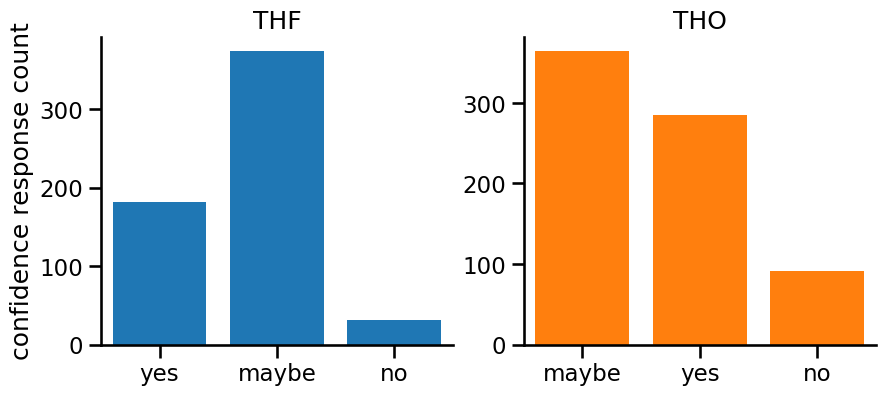

In [53]:
# Plot the confidence response for each task version
ax1, ax2 = make_axes(2, 2, figsize=(10, 4))
plot_bar(conf_THF.values(), labels=conf_THF.keys(),
         ylabel='confidence response count', title='THF', ax=ax1, color='C0')
plot_bar(conf_THO.values(), labels=conf_THO.keys(), title='THO', ax=ax2, color='C1')

drop_spines(ax1, ['top', 'right'])
drop_spines(ax2, ['top', 'right'])

## Successful vs. Unsuccessful recall
To-Dos:
* add behavioral analysis for successful vs. unsuccessful recall

## Units Overview

In [55]:
# Get the number of keep units per session 
units_session = np.zeros(len(nwbfiles))
for ind, nwbfile in enumerate(nwbfiles):
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    units_session[ind] = len(np.where(nwbfile.units.keep[:])[0])

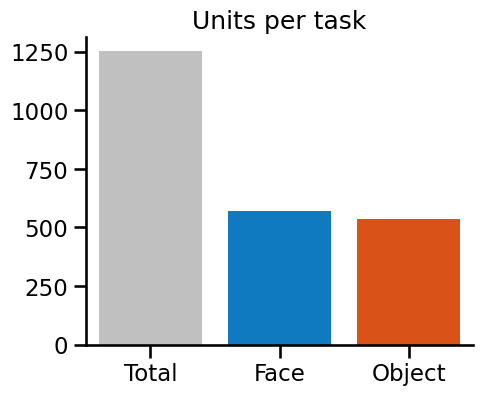

In [56]:
# Plot the number of units in each task
_, ax = plt.subplots(figsize=(5, 4))
plot_bar([sum(units_session), sum(units_session[1:10]), sum(units_session[11:22])],
         labels=['Total', 'Face', 'Object'], color=[colors['default'], colors['face'], colors['obj']],
         title='Units per task', ax=ax)
drop_spines(ax, ['top', 'right']) 
# save_figure('units_task'+'.svg', '/Users/clairehan/Desktop/paper_fig', close=False, bbox_inches='tight')

### Units per brain region & hemisphere

In [57]:
# Get the number of units per brain region
labels = ['LAH', 'RAH', 'LA', 'RA', 'RAH', 'RPH']
unit_all = []
for ind, nwbfile in enumerate(nwbfiles):
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    unit = nwbfile.units['location'].data[:]
    unit_all.append(unit)

unit_all = np.concatenate(unit_all).ravel()
unit_counts = count_elements(unit_all, labels=labels)

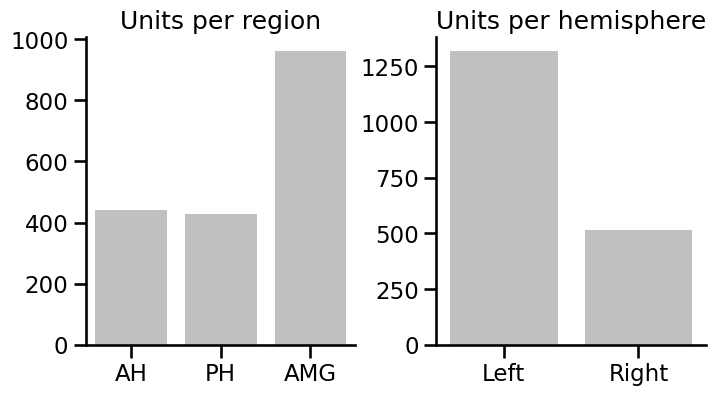

In [58]:
# Plot the number of units per brain region & hemisphere
ax1, ax2 = make_axes(2, 2, figsize=(8, 4), wspace=0.3)
plot_bar([unit_counts['LAH'] + unit_counts['RAH'], unit_counts['LPH'] + unit_counts['RPH'], unit_counts['LA'] + 
          unit_counts['RA']], ['AH', 'PH', 'AMG'], title='Units per region', color='silver', ax=ax1)
plot_bar([unit_counts['LAH'] + unit_counts['LPH'] + unit_counts['LA'], unit_counts['RAH'] + unit_counts['RPH'] 
          + unit_counts['RA']], ['Left', 'Right'], title='Units per hemisphere', color='silver', ax=ax2)
drop_spines(ax1, ['top', 'right'])
drop_spines(ax2, ['top', 'right'])

# save_figure('units_region'+'.svg', '/Users/clairehan/Desktop/paper_fig', close=False, bbox_inches='tight')